### Project Codename: Skeleton - HackaTUM 2022
In this notebook we provide our PoC code for our submission at the HackaTUM 2022 Rhode & Schwarz challenge. Our submission consists of a machine-learning model to detect wrong finger placement (possibility of fractures and injuries). We use real palm/hand images taken with the R&S®QAR50 Quality Automotive Radome Tester [website](https://www.rohde-schwarz.com/de/produkte/messtechnik/radomtester/rs-qar50_63493-1138625.html). 

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import cv2
import numpy as np
import os
from skimage import morphology, img_as_bool, img_as_ubyte
from PIL import Image
import torch
import torch.nn as nn

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

import pandas as pd

### Real input images from the R&S®QAR50

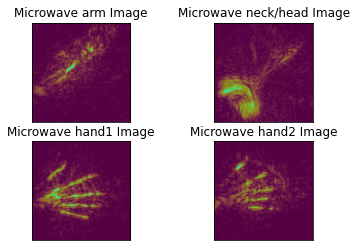

In [2]:
arm = cv2.imread('assets/showcase_images/arm_raw.png')
neck = cv2.imread('assets/showcase_images/neck_head_raw.png')
hand1 = cv2.imread('assets/showcase_images/hand_raw1.png')
hand2 = cv2.imread('assets/showcase_images/hand_raw2.png')

plt.subplot(221),plt.imshow(arm),plt.title('Microwave arm Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(neck,cmap = 'gray'),plt.title('Microwave neck/head Image'), plt.xticks([]), plt.yticks([])
plt.subplot(223),plt.imshow(hand1),plt.title('Microwave hand1 Image'), plt.xticks([]), plt.yticks([])
plt.subplot(224),plt.imshow(hand2),plt.title('Microwave hand2 Image'), plt.xticks([]), plt.yticks([])

plt.show()

### Preprocessing

In [3]:
file_path = "./assets/microwave" #input data

for index, element in enumerate(os.listdir(file_path)):
    file = os.path.join(file_path, element)
    image = Image.open(file).convert('LA')

    arr = np.array(image)

    # tresholding, blurring
    arr_new = arr[:,:,0]
    blur = cv2.bilateralFilter(arr_new,30,75,75)
    arr_new[blur<70]=0
    arr_new[arr_new!=0]=255

    #out = morphology.medial_axis(arr_new)
    #out = img_as_ubyte(out)
    arr_new = cv2.resize(arr_new, (640, 480), interpolation = cv2.INTER_AREA)
    #out = cv2.resize(out,(640, 480), interpolation = cv2.INTER_AREA)

    target_path = "./assets/preprocessed_out/"
    image_name = "postprocessed_hand_{}.jpg".format(index)
    #"skeletons" were used in an early implementation to detect finger positions using graph-algorithms
    #skeleton_name = "skeleton_hand_{}.jpg".format(index)

    cv2.imwrite(os.path.join(target_path, image_name), arr_new)
    #cv2.imwrite(os.path.join(target_path, skeleton_name), out)

    #plt.subplot(),plt.imshow(image),plt.title('Grayscale Microwave Image'),plt.xticks([]), plt.yticks([])
    #plt.subplot(),plt.imshow(arr_new),plt.title('Preprocessed Image'),plt.xticks([]), plt.yticks([])
    #plt.show()

### Dataset creation
We built our own palm dataset with normal and misaligned fingers (simulating possible injuries) derived from the postprocessed hand data (./assets/preprocessed_out/). We then used this dataset for our PoC on fracture/injury classification.

The misaligned images were produced by ourself, either taking microwave-scans with unusal finger placement or, by manipulating the images using Gimp.

* The misaligned dataset is at ./assets/misaligned/
* The dataset classified as non-injured is the one at ./assets/preprocessed_out/

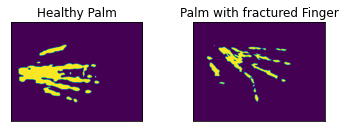

In [4]:
file_path_misaligned = "./assets/misaligned" 
file_path_healthy = "./assets/preprocessed_out" 

file_misaligned = os.path.join(file_path_misaligned, 'postprocessed_hand_130.jpg')
file_healthy = os.path.join(file_path_healthy, 'postprocessed_hand_112.jpg')

img_misaligned = Image.open(file_misaligned)
img_healthy = Image.open(file_healthy)

plt.subplot(221),plt.imshow(img_healthy),plt.title('Healthy Palm'),plt.xticks([]), plt.yticks([])
plt.subplot(222),plt.imshow(img_misaligned),plt.title('Palm with fractured Finger'),plt.xticks([]), plt.yticks([])
plt.show()

### Classification

In the next step, the images which were classified as "misaligned", are processed by a bounding box regression model in order to determine the position of the fracture.

In [5]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
            
        conv_layer1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False)
        
        conv_layer2 = nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False)
        
        
        self.double_conv = nn.Sequential(
            conv_layer1,# bias was false
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            conv_layer2,# bias was false
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)
    
    def normal_init(m, mean, std):
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            m.weight.data.normal_(mean, std)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [6]:

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 3)
        self.down1 = Down(3, 6)
        self.down2 = Down(6, 12)
        self.lin = torch.nn.Linear(12*120*160, 1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x3 = x3.flatten(start_dim=1)
        logit = self.lin(x3)
        return torch.nn.functional.sigmoid(logit)

In [7]:
model = UNet(n_channels=1, n_classes=2)
parameter_path = './assets/models/classifier_weights'
print('Path to model exists?')
print(os.path.exists(parameter_path))
model.load_state_dict(torch.load(parameter_path))

Path to model exists?
True


<All keys matched successfully>

In [8]:
img_array = np.array(img_healthy)
img_tensor = torch.tensor(img_array)
img_tensor = torch.unsqueeze(img_tensor, 0)
img_tensor = torch.unsqueeze(img_tensor, 0)
if model(img_tensor.float())[0] <= 0.5:
    print("no fracture")
else:
    print("fracture detected")

no fracture


/home/thilo/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


### Fraction Localization

In [10]:
img_array = np.array(img_misaligned)
img_tensor = torch.tensor(img_array)
img_tensor = torch.unsqueeze(img_tensor, 0)
img_tensor = torch.unsqueeze(img_tensor, 0)
if model(img_tensor.float())[0] <= 0.5:
    print("no fracture")
else:
    print("fracture detected")

fracture detected


In [11]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [12]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

In [13]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [14]:
# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


In [15]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [16]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [17]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [18]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [19]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [20]:
# load the model parameters
device = torch.device('cpu')
model = BB_model()
model.load_state_dict(torch.load("./assets/models/model.pth", map_location=device))
model.eval()

/home/thilo/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/thilo/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


BB_model(
  (features1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [28]:
# resizing test image
im = read_image('./assets/misaligned/postprocessed_hand_130.jpg')
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite('./assets/bb_images/postprocessed_hand_130.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [29]:
# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':'./assets/bb_images/postprocessed_hand_130.jpg'}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

/tmp/ipykernel_10987/83097149.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


In [30]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [31]:
# prediction
out_class, out_bb = model(xx)

[191 189 258 297]


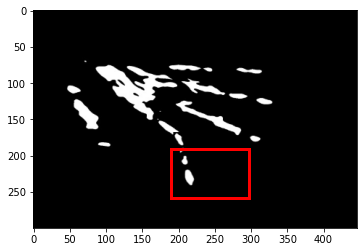

In [32]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])
print(bb_hat[0])